# Estimating Causal Effect for Driver-Incentive Program Experiment

## Experiment Setup and Dataset Summary
This dataset originates from a three-month randomized controlled trial (RCT) conducted by a ride-hailing firm to test a new driver incentive program.
- Purpose: Assess the program’s impact on the following key driver outcomes
    - minutes driven per day
    - probability of driving per day
    - earnings per day

- Context: The program was anticipated to be popular among drivers, and participating cities were eager to implement it.

- Driver Qualification:
    - Drivers were eligible for entering the experiment based on several criteria, the most important being activity level in the previous month.
    - For instance, only drivers in the top quartile of total minutes driven within their city qualified.

- Rollout Design:
    - Each city was given a designated start date and a standardized SQL query to identify *qualified* drivers.
    - On the start date, cities would begin to take the list of all eligible drivers on that date, stratifying them by recent activity levels (mostly minutes driven in the last month).
    - Importantly, following their start dates, cities re-run the SQL query daily to identify and enroll newly qualified drivers, who were then similarly stratified and added to the experiment.

- Experiment Assignment:
    - Qualified drivers were restrictively randomized to treatment or control groups after stratification.
    - This process was ongoing, with new drivers added throughout the trial as they became eligible.

- Treatment vs. Control:
    - Treated drivers received an email introducing the incentive and instructions on how to apply (acceptance is not automatic and is subject to meeting financial criteria).
    - Control drivers received a similar email but were informed that the incentive would be available soon.

### Project Scope
In this notebook, I explore several commonly used causal inference methods and discuss why some are unsuitable for this experimental setting. The goal is to understand when and why to use each method to uncover the true causal effect.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from linearmodels.panel import PanelOLS
from linearmodels.iv.absorbing import AbsorbingLS
import matplotlib.pyplot as plt
from linearmodels.iv import IV2SLS

## Understanding the Data

In [2]:
daysdf = pd.read_csv('data/Driver_Days.csv')
conditiondf = pd.read_csv('data/Driver_Condition.csv')
enrollmentdf = pd.read_csv('data/Driver_Enrollment.csv')
daysdf.head(10)

,Date,Earnings_Dollars,DistanceDriven_Miles,TimeDriving_Minutes,Driver_ID
0,04mar2016,86,69,257,1
1,05mar2016,103,54,212,1
2,06mar2016,185,124,414,1
3,07mar2016,21,18,69,1
4,08mar2016,59,50,257,1
5,10mar2016,142,103,544,1
6,11mar2016,131,88,296,1
7,12mar2016,173,66,269,1
8,13mar2016,129,72,303,1
9,15mar2016,105,52,219,1


Notice from above that observations where the driver chose not to drive that day are unavailable. Hence, adding the skipped dates is needed to create a balanced panel of data.

In [3]:
daysdf['Date'] = pd.to_datetime(daysdf['Date'], format='%d%b%Y')

driver_ranges = daysdf.groupby('Driver_ID')['Date'].agg(['min', 'max']).reset_index()
all_rows = []

for _, row in driver_ranges.iterrows():
    driver_id = row['Driver_ID']
    date_range = pd.date_range(start=row['min'], end=row['max'], freq='D')
    temp = pd.DataFrame({
        'Driver_ID': driver_id,
        'Date': date_range,
    })
    all_rows.append(temp)

full_driver_days = pd.concat(all_rows, ignore_index=True)
daysdf_balanced = full_driver_days.merge(daysdf, on=['Driver_ID', 'Date'], how='left')

for col in ['Earnings_Dollars', 'DistanceDriven_Miles', 'TimeDriving_Minutes']:
    daysdf_balanced[col] = daysdf_balanced[col].fillna(0)
    
daysdf_balanced['Drove'] = (daysdf_balanced['TimeDriving_Minutes'] > 0).astype(int)

daysdf_balanced.head(10)

,Driver_ID,Date,Earnings_Dollars,DistanceDriven_Miles,TimeDriving_Minutes,Drove
0,1,2016-03-04,86.0,69.0,257.0,1
1,1,2016-03-05,103.0,54.0,212.0,1
2,1,2016-03-06,185.0,124.0,414.0,1
3,1,2016-03-07,21.0,18.0,69.0,1
4,1,2016-03-08,59.0,50.0,257.0,1
5,1,2016-03-09,0.0,0.0,0.0,0
6,1,2016-03-10,142.0,103.0,544.0,1
7,1,2016-03-11,131.0,88.0,296.0,1
8,1,2016-03-12,173.0,66.0,269.0,1
9,1,2016-03-13,129.0,72.0,303.0,1


Merging the data.

In [4]:
df = daysdf_balanced.merge(conditiondf, on='Driver_ID', how='inner')
df['Driver_ExperStartDate'] = pd.to_datetime(df['Driver_ExperStartDate'], format='%d%b%Y')

df['DaysSinceStart'] = (df['Date'] - df['Driver_ExperStartDate']).dt.days.clip(lower=0).astype(int)

df = df.merge(enrollmentdf, on='Driver_ID', how='left')

df['AppliedDate'] = pd.to_datetime(df['Applied'], format='%d%b%Y')
df['EnrolledDate'] = pd.to_datetime(df['Enrolled'], format='%d%b%Y')

df['EverApplied'] = df['AppliedDate'].notnull().astype(int)
df['EverEnrolled'] = df['EnrolledDate'].notnull().astype(int)

df['Applied'] = (df['Date'] >= df['AppliedDate']).astype(int)
df['Enrolled'] = (df['Date'] >= df['EnrolledDate']).astype(int)

Since treated drivers receive an email introducing the incentive along with instructions on how to apply, there is typically a delay before they take action—such as applying, enrolling, or beginning to use the program. As a result, the experiment's impact may not be immediate, even after the official start date.

This necessitates a careful decision on how to *define the “post-treatment” period*. The trade-off is as follows:
- **If defined too early**: While this includes the full sample, most drivers have not yet acted, leading to low take-up and a potentially underestimated treatment effect.
- **If defined too late**: While take-up is higher and effects may appear more pronounced, fewer drivers have been observed for that duration, leading to a reduced sample size and potential selection bias toward early entrants—who, as we will discuss later, differ in important ways from newer entrants in the sample.

To assess the extent of this trade-off, particularly how much of the sample is affected by shorter observation windows, we begin by visualizing the distribution of observations by the number of days since (driver-specific) experiment start date.

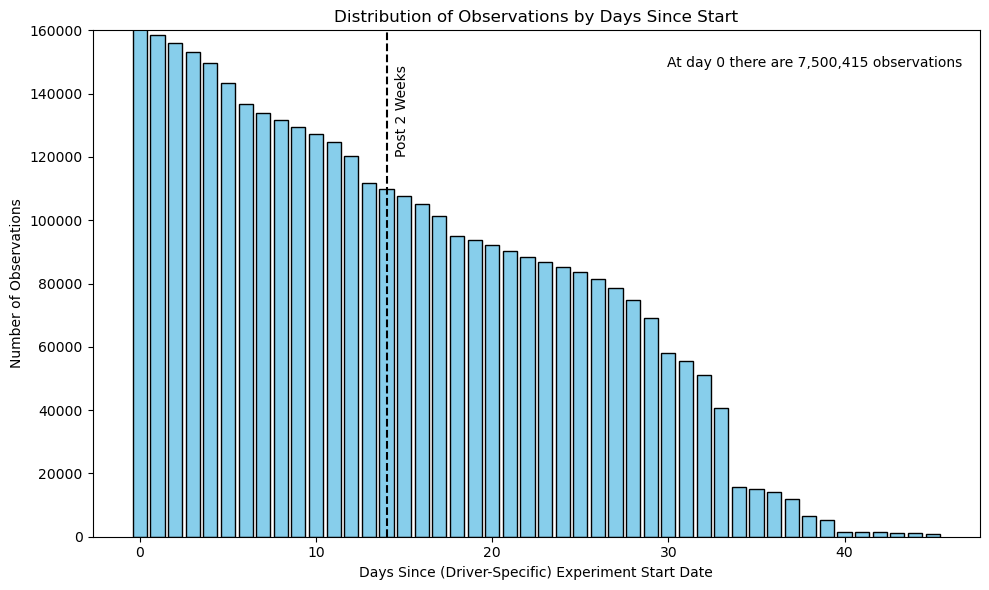

In [5]:
day_counts = df['DaysSinceStart'].value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.bar(day_counts.index, day_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Days Since (Driver-Specific) Experiment Start Date')
plt.ylabel('Number of Observations')
plt.title('Distribution of Observations by Days Since Start')
plt.ylim(0, 160000)

plt.axvline(x=14, color='black', linestyle='--')
plt.text(14.5, 120000, 'Post 2 Weeks', rotation=90, verticalalignment='bottom')

if 0 in day_counts.index:
    obs_count = f"{day_counts.loc[0]:,}"
    plt.text(0.98, 0.95, f"At day 0 there are {obs_count} observations", 
             ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)

plt.tight_layout()
plt.show()

A application and enrollment rate amonst the treated can be used to assess when the experiment starts to take effect.

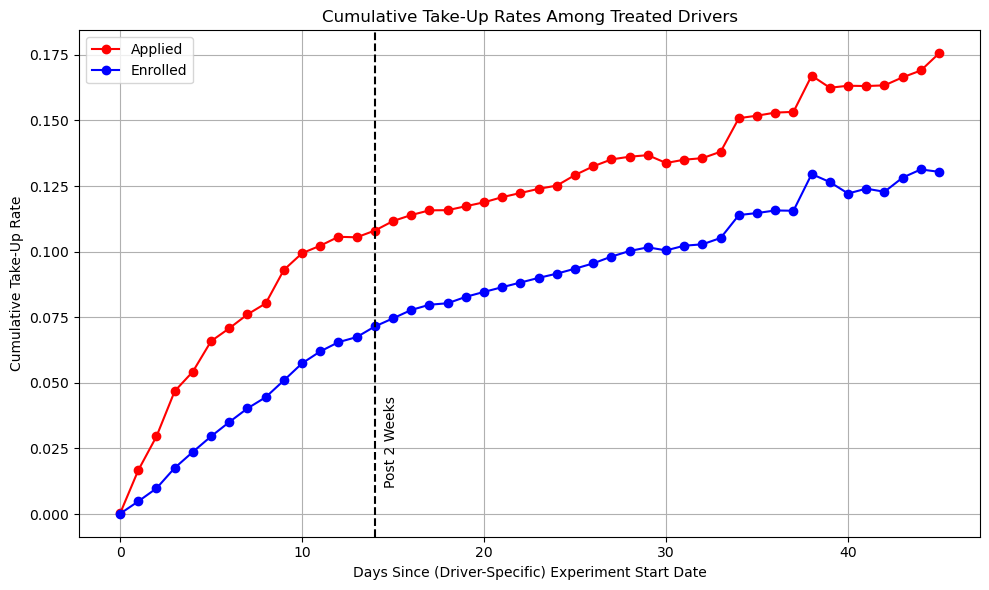

In [6]:
takeup = (
    df[df['Treated'] == 1]
    .groupby('DaysSinceStart')[['Applied', 'Enrolled']]
    .mean()
)

plt.figure(figsize=(10,6))
plt.plot(takeup.index, takeup['Applied'], label='Applied', color='red', marker='o')
plt.plot(takeup.index, takeup['Enrolled'], label='Enrolled', color='blue', marker='o')

plt.axvline(x=14, color='black', linestyle='--')
plt.text(14.5, 0.01, 'Post 2 Weeks', rotation=90, verticalalignment='bottom')

plt.xlabel('Days Since (Driver-Specific) Experiment Start Date')
plt.ylabel('Cumulative Take-Up Rate')
plt.title('Cumulative Take-Up Rates Among Treated Drivers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Based on the two graphs above, setting the post-treatment period at three weeks strikes a reasonable balance: it retains a substantial portion of the sample while ensuring that cumulative take-up rates have reached a meaningful level.

In [7]:
df['After'] = (df['Date'] >= df['Driver_ExperStartDate'] + pd.Timedelta(days=14)).astype(int)
df = df[[
    'Driver_ID', 'Driver_City', 'Driver_ExperStartDate', 'Date',
    'AppliedDate', 'EnrolledDate', 'DaysSinceStart',
    'Earnings_Dollars', 'DistanceDriven_Miles', 'TimeDriving_Minutes',
    'Drove', 'Treated', 'After', 
    'Applied', 'Enrolled', 'EverApplied', 'EverEnrolled'
]]

df.head()

,Driver_ID,Driver_City,Driver_ExperStartDate,Date,AppliedDate,EnrolledDate,DaysSinceStart,Earnings_Dollars,DistanceDriven_Miles,TimeDriving_Minutes,Drove,Treated,After,Applied,Enrolled,EverApplied,EverEnrolled
0,1,26,2016-03-30,2016-03-04,NaT,NaT,0,86.0,69.0,257.0,1,0,0,0,0,0,0
1,1,26,2016-03-30,2016-03-05,NaT,NaT,0,103.0,54.0,212.0,1,0,0,0,0,0,0
2,1,26,2016-03-30,2016-03-06,NaT,NaT,0,185.0,124.0,414.0,1,0,0,0,0,0,0
3,1,26,2016-03-30,2016-03-07,NaT,NaT,0,21.0,18.0,69.0,1,0,0,0,0,0,0
4,1,26,2016-03-30,2016-03-08,NaT,NaT,0,59.0,50.0,257.0,1,0,0,0,0,0,0


## Standard A/B Testing Approach
One might see an experimental setup and immediately be inclined to a standard A/B testing procedure to estimating the effect. 
- (The sample is stratified and randomized into treatment and control, what could go wrong?)
- I want to demonstrate why a standard A/B testing procedure might produce misleading results in this setting and why it should be used carefully.

I will demonstrate a standard A/B testing procedure.

### Pre-Treatment Balance Check
First, I will check pre-treatment balance between the treatment and control groups, to ensure that any observed post-treatment differences in outcomes can credibly be attributed to the treatment and not to pre-existing differences between the groups.

Since stratification and experiment assignment takes place at the city level, controlling for `Driver_City` is needed.

Since assignment is clustered (by driver), cluster-robust standard errors are needed for accurate results.

$$\text{TimeDriving\_Minutes}_{i, \text{pre}} = \beta_0 + \beta_1 \text{Treated}_i + \sum_{c=1}^{C-1} \gamma_c \text{Driver\_City}_{ic} + \epsilon_i$$

In [8]:
pre_treatment_df = df[df['After'] == 0]
model = smf.ols('TimeDriving_Minutes ~ Treated + C(Driver_City)', data=pre_treatment_df).fit(cov_type='cluster', cov_kwds={'groups': pre_treatment_df['Driver_ID']})
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     TimeDriving_Minutes   R-squared:                       0.024
Model:                             OLS   Adj. R-squared:                  0.024
Method:                  Least Squares   F-statistic:                     421.3
Date:                 Sun, 15 Jun 2025   Prob (F-statistic):               0.00
Time:                         19:28:02   Log-Likelihood:            -6.2779e+07
No. Observations:              9277600   AIC:                         1.256e+08
Df Residuals:                  9277569   BIC:                         1.256e+08
Df Model:                           30                                         
Covariance Type:               cluster                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

The p-value is incredibly high, meaning that the assignment of treatment is not statistically significant. This suggests that the treatment and control groups are randomized as expected.

In [9]:
print(f"Treated p-value: {model.pvalues['Treated']:.4f}")

Treated p-value: 0.7975


### Standard A/B Testing Regression

$$\text{TimeDriving\_Minutes}_{i, \text{post}} = \beta_0 + \beta_1 \text{Treated}_i + \sum_{c=1}^{C-1} \gamma_c \text{Driver\_City}_{ic} + \epsilon_i$$

In [10]:
post_treatment_df = df[df['After'] == 1]
model = smf.ols('TimeDriving_Minutes ~ Treated + C(Driver_City)', data=post_treatment_df).fit(cov_type='cluster', cov_kwds={'groups': post_treatment_df['Driver_ID']})
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     TimeDriving_Minutes   R-squared:                       0.008
Model:                             OLS   Adj. R-squared:                  0.008
Method:                  Least Squares   F-statistic:                     187.1
Date:                 Sun, 15 Jun 2025   Prob (F-statistic):               0.00
Time:                         19:28:10   Log-Likelihood:            -1.1738e+07
No. Observations:              1724948   AIC:                         2.348e+07
Df Residuals:                  1724934   BIC:                         2.348e+07
Df Model:                           13                                         
Covariance Type:               cluster                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

In [11]:
print(f"Treated p-value: {model.pvalues['Treated']:.4f}")

level_effect = model.params['Treated']
print(f"Level effect: {level_effect:.2f} minutes increase per day")

control_mean = post_treatment_df[post_treatment_df['Treated'] == 0]['TimeDriving_Minutes'].mean()

percent_effect = 100 * level_effect / control_mean
print(f"Percent effect: {percent_effect:.2f}% relative to control group mean of {control_mean:.2f} minutes per day")

Treated p-value: 0.0001
Level effect: 3.41 minutes increase per day
Percent effect: 1.94% relative to control group mean of 175.44 minutes per day


While the results might look convincing, this is very misleading due to the following reasons:
- Ommited Variable Bias
    - The regression does not control for driver-specific characteristics or time fixed effects.
    - Without these controls, differences in behavior across drivers or over time can bias the estimated treatment effect.
- No Use of Pre-treatment Baseline
    - The model ignores pre-treatment outcomes, missing the opportunity to adjust for baseline differences in driving behavior across treatment and control groups.
- Staggered Treatment Assignment
    - Drivers are enrolled on different dates across cities.
    - Failing to account for this timing can confound treatment effects with calendar effects such as seasonality, market shifts, or external shocks.
- Rolling Enrollment and Selection Bias
    - Drivers were continuously added to the experiment as they became newly eligible.
    - Without accounting for entry timing, the model risks comparing drivers at different stages or with different underlying characteristics, leading to biased estimates.

### Standard Regression with Time Fixed Effects
In the later sections of this notebook, these biases will be addressed using more appropriate techniques. We begin by adding time and driver fixed effects to mitigate omitted variable bias in the panel data setting.

Notice that we cannot add driver fixed effects to our regression because of its collinearity with treated.

$$\text{TimeDriving\_Minutes}_{i, \text{post}} = \beta_0 + \beta_1 \text{Treated}_i + \sum_{c=1}^{C-1} \gamma_c \text{Driver\_City}_{ic} + \sum_{d=1}^{D-1} \delta_d \text{Date}_{td} + \epsilon_i$$

In [12]:
model = smf.ols('TimeDriving_Minutes ~ Treated + C(Driver_City) + C(Date)', data=post_treatment_df).fit(cov_type='cluster', cov_kwds={'groups': post_treatment_df['Driver_ID']})
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     TimeDriving_Minutes   R-squared:                       0.045
Model:                             OLS   Adj. R-squared:                  0.045
Method:                  Least Squares   F-statistic:                     1444.
Date:                 Sun, 15 Jun 2025   Prob (F-statistic):               0.00
Time:                         19:28:32   Log-Likelihood:            -1.1706e+07
No. Observations:              1724948   AIC:                         2.341e+07
Df Residuals:                  1724903   BIC:                         2.341e+07
Df Model:                           44                                         
Covariance Type:               cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [13]:
print(f"Treated p-value: {model.pvalues['Treated']:.4f}")

level_effect = model.params['Treated']
print(f"Level effect: {level_effect:.2f} minutes increase per day")

control_mean = post_treatment_df[post_treatment_df['Treated'] == 0]['TimeDriving_Minutes'].mean()
percent_effect = 100 * level_effect / control_mean
print(f"Percent effect: {percent_effect:.2f}% relative to control group mean of {control_mean:.2f} minutes per day")

Treated p-value: 0.0001
Level effect: 3.33 minutes increase per day
Percent effect: 1.90% relative to control group mean of 175.44 minutes per day


## Difference-in-Differences
It has been mentioned that the previous model ignores pre-treatment outcomes, missing the opportunity to adjust for baseline differences in driving behavior across treatment and control groups.

The following regression implements a difference-in-differences (DiD) approach, which compares changes in outcomes before and after treatment across treated and control drivers 

— allowing us to isolate the treatment effect from underlying trends.

$$\text{TimeDriving\_Minutes}_{it} = \beta_0 + \beta_1 \text{After}_{it} + \beta_2 \text{Treated}_{i} \times \text{After}_{it} + \mu_i + \lambda_t + \epsilon_{it}$$

* $\beta_2$: This is the coefficient for the Interaction term (`Treated`×`After`), which represents the DiD estimator. It captures the causal effect of the treatment.
* $\mu_i$: This represents the EntityEffects (driver-specific fixed effects), accounting for unobserved, time-invariant characteristics of each driver.
* $\lambda_t$: This represents the TimeEffects (time-specific fixed effects), accounting for unobserved shocks common to all drivers at a specific time.
* $\epsilon_{it}$: This is the error term, representing unobserved factors not included in the model.

In [14]:
# smf gives memory error when using large datasets, so we use linearmodels instead
df_panel = df.copy()
df_panel = df_panel.set_index(['Driver_ID', 'Date'])
df_panel['Interaction'] = df_panel['Treated'] * df_panel['After']

model = PanelOLS.from_formula(
    'TimeDriving_Minutes ~ After + Interaction + EntityEffects + TimeEffects', # omit treated to avoid collinearity with entity (driver id)
    data=df_panel
).fit(cov_type='clustered', cluster_entity=True, low_memory=True)

print(model.summary)

                           PanelOLS Estimation Summary                           
Dep. Variable:     TimeDriving_Minutes   R-squared:                      2.15e-05
Estimator:                    PanelOLS   R-squared (Between):              0.0035
No. Observations:             11002548   R-squared (Within):            8.175e-05
Date:                 Sun, Jun 15 2025   R-squared (Overall):              0.0024
Time:                         19:29:21   Log-likelihood                -7.235e+07
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      115.67
Entities:                       243557   P-value                           0.0000
Avg Obs:                        45.174   Distribution:              F(2,10758930)
Min Obs:                        1.0000                                           
Max Obs:                        60.000   F-statistic (robust):             54.655
                

In [15]:
level_effect = model.params['Interaction']
print(f"Level effect (DiD estimate): {level_effect:.2f} minutes increase in time driven per day")

control_pre_mean = df_panel[(df_panel['Treated'] == 0) & (df_panel['After'] == 0)]['TimeDriving_Minutes'].mean()

percent_effect = 100 * level_effect / control_pre_mean
print(f"Percent effect: {percent_effect:.2f}% increase relative to control group's pre-treatment average of {control_pre_mean:.2f} minutes per day")

Level effect (DiD estimate): 1.68 minutes increase in time driven per day
Percent effect: 1.04% increase relative to control group's pre-treatment average of 160.79 minutes per day


The results seem to indicate that the driver-incentive program has little effect on number of minutes driven. 

However, it's important to revisit how the experiment was implemented: within each city, new SQL queries were re-run daily to identify and add newly qualified drivers into the control and treatment groups.

This means that **eligibility**, and therefore inclusion in the experiment, is **directly tied to recent driver activity**. For a driver to newly qualify, they must have increased their activity enough to move into the top quartile of driving minutes in the previous month.

**This creates a serious concern for a DiD setup**, which relies on the exogeneity of treatment timing. In this case, some "treated" drivers were enrolled early, while others only became eligible later due to an uptick in recent activity. As a result, the DiD estimator may compare the post-treatment outcomes of early-treated drivers to the pre-treatment outcomes of later-treated (but highly active) drivers.

Since these later entrants are especially active by design, this contaminates the counterfactual, leading to a downward bias in the estimated treatment effect — i.e., the true causal effect may be underestimated.

### Addressing Endogeneity Concerns Using Interaction Fixed Effects

It’s important to note that stratification and experiment assignment occur within each release date cohort, not across them. Therefore, by controlling for experiment cohorts (defined as `Driver_City` x `Driver_ExperStartDate`), comparisons are made at the driver and date level within the same cohort, where a cohort is defined by a unique combination of `Driver_City` and `Driver_ExperStartDate`. Since `Date` is also being controlled, this means we are isolating variation across treated and control drivers on the same calendar day within the same rollout group, controlling for both location-specific and temporal confounders.

$$\text{TimeDriving\_Minutes}_{it} = \beta_1 \text{Treated}_i + \beta_2 \text{After}_{it} + \beta_3 (\text{Treated}_{i} \times \text{After}_{it}) + \mu_{\text{city}_i, \text{expstart}_i} + \lambda_t + \epsilon_{it}$$

In [16]:
# To avoid memory issues with large datasets, we use the AbsorbingLS package
df_panel = df_panel.reset_index()
df_panel['Interaction'] = df_panel['After'] * df_panel['Treated']

y = df_panel['TimeDriving_Minutes']
X = df_panel[['Treated', 'After', 'Interaction']]

df_panel['City_Cohort_FE'] = pd.Categorical(df_panel['Driver_City'].astype(str) + "_" + df_panel['Driver_ExperStartDate'].astype(str))
df_panel['Date_FE'] = pd.Categorical(df_panel['Date'])

absorb = df_panel[['City_Cohort_FE', 'Date_FE']]

model = AbsorbingLS(y, X, absorb=absorb)
result = model.fit(cov_type='clustered', clusters=df_panel['Driver_ID'])

print(result.summary)

                          Absorbing LS Estimation Summary                          
Dep. Variable:     TimeDriving_Minutes   R-squared:                          0.0665
Estimator:                Absorbing LS   Adj. R-squared:                     0.0665
No. Observations:             11002548   F-statistic:                        42.126
Date:                 Sun, Jun 15 2025   P-value (F-stat):                   0.0000
Time:                         19:30:39   Distribution:                      chi2(3)
Cov. Estimator:              clustered   R-squared (No Effects):              1e-05
                                         Variables Absorbed:                 1041.0
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
Treated         0.2061     0.4891     0.4214     0.6734     -0.7525      1.1648
After   

In [17]:
level_effect = result.params['Interaction']
print(f"Level effect (DiD estimate): {level_effect:.2f} minutes increase in time driven per day")

control_pre_mean = df_panel[(df_panel['Treated'] == 0) & (df_panel['After'] == 0)]['TimeDriving_Minutes'].mean()
percent_effect = 100 * level_effect / control_pre_mean
print(f"Percent effect: {percent_effect:.2f}% increase relative to control group’s pre-treatment average of {control_pre_mean:.2f} minutes per day")

Level effect (DiD estimate): 3.08 minutes increase in time driven per day
Percent effect: 1.92% increase relative to control group’s pre-treatment average of 160.79 minutes per day


#### An Alternative Method: Cohort x Date Fixed Effects

An alternative specification is to include `Cohort` × `Date` fixed effects instead of separate `Cohort` fixed effects and `Date` fixed effects. This allows the estimation to flexibly vary across time within each cohort, thereby absorbing more variation and controlling for any time-varying unobservables that may differ across cohorts.

However, when `Cohort` × `Date` fixed effects are included, the `After` indicator becomes perfectly collinear with these fixed effects, because for each cohort, we know exactly when the post-treatment period starts. In other words, the `After` variable is fully captured by the interaction of cohort and calendar date. Thus, it should be omitted from the regression to avoid multicollinearity.

Additionally, since `Treated` is exogenous and is restrictively randomly assigned, it should not have any effect on the outcome variable. Hence, it can be ommitted for simplicity. Therefore, the identifying variation comes entirely from the interaction term `Treated` × `After`, which varies both across units and over time. This term captures the intent-to-treat effect in a difference-in-differences framework.

$$\text{TimeDriving\_Minutes}_{it} = \beta_1 (\text{Treated}_{i} \times \text{After}_{it}) + \mu_{\text{city}_i, \text{expstart}_i, \text{date}_t} + \epsilon_{it}$$

In [18]:
y = df_panel['TimeDriving_Minutes']
X = df_panel['Interaction']

df_panel['City_Cohort_Date_FE'] = pd.Categorical(df_panel['Driver_City'].astype(str) + "_" + df_panel['Driver_ExperStartDate'].astype(str) + "_" + df_panel['Date'].astype(str))

absorb = df_panel[['City_Cohort_Date_FE']]

model = AbsorbingLS(y, X, absorb=absorb)
result = model.fit(cov_type='clustered', clusters=df_panel['Driver_ID'])

print(result.summary)

                          Absorbing LS Estimation Summary                          
Dep. Variable:     TimeDriving_Minutes   R-squared:                          0.0767
Estimator:                Absorbing LS   Adj. R-squared:                     0.0719
No. Observations:             11002548   F-statistic:                        15.330
Date:                 Sun, Jun 15 2025   P-value (F-stat):                   0.0001
Time:                         19:31:27   Distribution:                      chi2(1)
Cov. Estimator:              clustered   R-squared (No Effects):              1e-05
                                         Variables Absorbed:              5.716e+04
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
Interaction     3.3537     0.8566     3.9154     0.0001      1.6749      5.0326


In [19]:
level_effect = result.params['Interaction']
print(f"Level effect (DiD estimate): {level_effect:.2f} minutes increase in time driven per day")

control_pre_mean = df_panel[(df_panel['Treated'] == 0) & (df_panel['After'] == 0)]['TimeDriving_Minutes'].mean()
percent_effect = 100 * level_effect / control_pre_mean
print(f"Percent effect: {percent_effect:.2f}% increase relative to control group’s pre-treatment average of {control_pre_mean:.2f} minutes per day")

Level effect (DiD estimate): 3.35 minutes increase in time driven per day
Percent effect: 2.09% increase relative to control group’s pre-treatment average of 160.79 minutes per day


The estimated effect is larger than in the first DiD regression that we ran, supporting our hypothesis that later entrants may be more active than early ones.

It's important to remember that this is an Intent-to-Treat (ITT) estimate. At first glance, the effect size may appear to be mediocre, potentially suggesting that the incentive program isn’t very effective. However, keep in mind that the treatment here simply involved sending an email invitation, not actual program participation. In fact, the cumulative application rate never exceeds 18%, meaning that the majority of treated drivers never enrolled.

This raises a natural question: *Can we estimate the effect of the program on those who actually applied or enrolled?* 

A tempting approach might be to rerun the regression using `Applied` or `Enrolled` as the treatment indicator. However, both application and enrollment are endogenous, meaning that they’re likely influenced by unobserved factors (e.g., driver motivation or income needs) that also affect outcomes. As a result, the coefficients from such a model would be biased and not causal. For example, drivers who choose to apply may be more financially motivated and would likely drive more regardless of the program, making it difficult to isolate the program’s true impact.

![](DAG.png)

## Instrumental Variables Regression

To estimate the true causal effect of program enrollment (`Enrolled`) on driving time (`TimeDriving_Minutes`), we can use an econometric method called Instrumental Variable (IV) Regression. This approach helps address the endogeneity of `Enrolled`, which may be influenced by unobserved confounders like motivation or financial pressure, by isolating only the variation in `Enrolled` that is not confounded.

We propose using `Treated` (i.e., whether a driver was assigned to receive the promotional email) as an instrument for `Enrolled`, under the following two assumptions:

- **Relevance**: A driver must be assigned `Treated` in order to enroll, so treatment assignment is strongly correlated with enrollment.
- **Exclusion Restriction**: Treatment assignment affects driving time only through enrollment, and not through any other channel.

If these assumptions hold, then `Treated` can serve as a valid instrument, and the IV estimate will capture the **Local Average Treatment Effect (LATE)**—i.e., the causal effect of enrolling for those who enroll only because they were treated (compliers).

In our context, it can be convincingly argued that these two assumptions hold.

In [20]:
df_panel.drop(columns=['Interaction'], inplace=True)
df_panel.to_csv('data/Processed_Data.csv', index=False)

Since R has more variety in IV packages, the following analysis will be conducted in R.